In [64]:
# Loading libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [65]:
# Import the dataset
kickstarter = pd.read_excel('Kickstarter.xlsx')

In [77]:
# For the purpose of this project, we only need to include projects with "successful" or "failure" state
df = kickstarter[kickstarter['state'].isin(['successful','failed'])]

# Convert the target variable to binary
df['state'] = df['state'].replace(['successful','failed'],[1,0])

df.head()

C:\Users\shans\AppData\Local\Temp\ipykernel_21916\2678655226.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['state'] = df['state'].replace(['successful','failed'],[1,0])


,id,name,goal,pledged,state,disable_communication,country,currency,deadline,state_changed_at,...,created_at_day,created_at_yr,created_at_hr,launched_at_month,launched_at_day,launched_at_yr,launched_at_hr,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days
0,1601563193,Our future,100000000.0,1.00,0,False,AU,AUD,2014-10-07 12:05:39,2014-10-07 12:05:39,...,1,2014,21,8,8,2014,12,6,60,60
1,880009511,Elite: Dangerous,1250000.0,1578316.08,1,False,GB,GBP,2013-01-04 18:00:57,2013-01-04 18:00:57,...,31,2012,11,11,5,2012,18,5,60,60
4,557230947,"Bring Reading Rainbow Back for Every Child, Ev...",1000000.0,5408916.95,1,False,US,USD,2014-07-02 14:00:00,2014-07-02 14:00:11,...,22,2014,22,5,28,2014,8,35,35,35
5,1966069095,ARKYD: A Space Telescope for Everyone,1000000.0,1505366.60,1,False,US,USD,2013-06-30 21:00:00,2013-06-30 21:00:34,...,10,2012,17,5,29,2013,10,322,32,32
6,2083255961,A Billion Pixels...,100000000.0,56.00,0,False,US,USD,2014-08-04 16:39:34,2014-08-04 16:39:34,...,1,2014,16,6,5,2014,16,34,60,60


# 1. Data Preprocessing

In [78]:
# Understand the data type of each column
df.dtypes

id                                      int64
name                                   object
goal                                  float64
pledged                               float64
state                                   int64
disable_communication                    bool
country                                object
currency                               object
deadline                       datetime64[ns]
state_changed_at               datetime64[ns]
created_at                     datetime64[ns]
launched_at                    datetime64[ns]
staff_pick                               bool
backers_count                           int64
static_usd_rate                       float64
usd_pledged                           float64
category                               object
spotlight                                bool
name_len                              float64
name_len_clean                        float64
blurb_len                             float64
blurb_len_clean                   

Clustering algorithms do not work well with categorical variable (either binary or multi-class), especially K-Means.

We should consider removing all categorical variables. (Note: day, month, year are also considered categorical)

In [80]:
# Select only numeric values
numerics = ['float16', 'float32', 'float64'] #In this dataset, only float are numeric; int are dateTime values

df = df.select_dtypes(include=numerics)
df.columns

Index(['goal', 'pledged', 'static_usd_rate', 'usd_pledged', 'name_len',
       'name_len_clean', 'blurb_len', 'blurb_len_clean'],
      dtype='object')

Check if there is any collinearity between variables

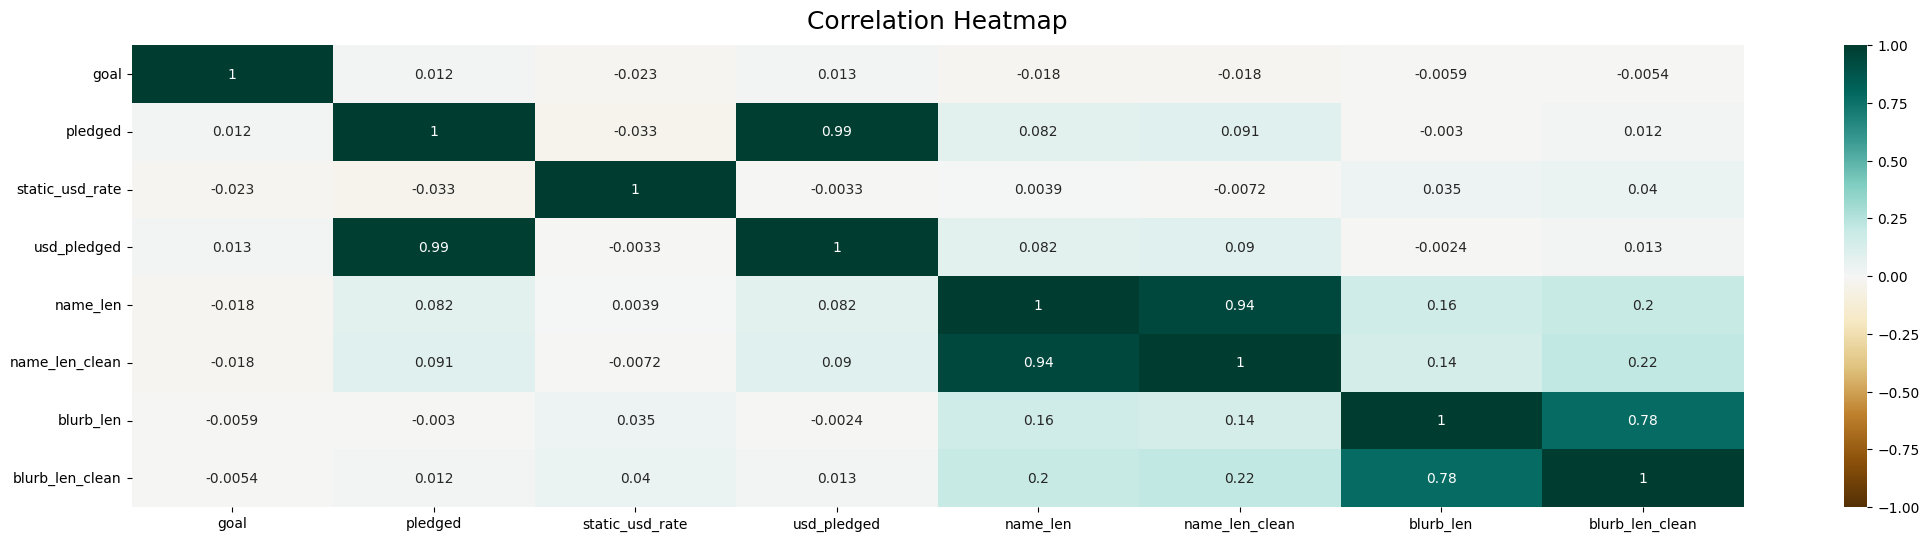

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(26, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap_clustering.png', dpi=300, bbox_inches='tight')

According to the correlation heatmap, following varaibles have high correlation:
- usd_pledged and pledged,
- name_len and name_len_clean, 
- blurb_len and blurb_len_clean,

For each pair, we only need to keep one of them.

In [82]:
df = df.drop(columns = ['usd_pledged','name_len_clean','blurb_len_clean'])
df.columns

Index(['goal', 'pledged', 'static_usd_rate', 'name_len', 'blurb_len'], dtype='object')

# 2. K-Means Clustering

In [83]:
X = df

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [84]:
from sklearn.cluster import KMeans

K = 5
kmeans = KMeans(n_clusters=K)
model = kmeans.fit(X_std)
labels = model.predict(X_std)

for i in range(K):
    print(i, (labels == i).sum())

0 6143
1 1707
2 5527
3 53
4 5


## 2.1 Find the optimal K

# 3. Agglomerative Approach

In [71]:
from sklearn.cluster import AgglomerativeClustering

K = 2
cluster = AgglomerativeClustering(n_clusters=K,affinity='euclidean',linkage='complete')
cluster.fit_predict(X_std)
labels = cluster.labels_

for i in range(K):
    print(i, (cluster.labels_ == i).sum())


0 13434
1 1


# 3. Clusters Measurement

## 3.1 Slihouette Method

In [62]:
from sklearn.metrics import silhouette_samples
silhouette = silhouette_samples(X_std, labels)
silhouette # silhouette score for each indiviual data points
           # > 0.5 is strong

df['lables'] = labels
df['silhouette'] = silhouette

df.head()

,goal,pledged,state,backers_count,static_usd_rate,name_len,blurb_len,clusters,lables,silhouette
0,100000000.0,1.00,0,1,0.928942,2.0,24.0,8,2,0.001967
1,1250000.0,1578316.08,1,25681,1.602618,2.0,22.0,5,0,0.016150
4,1000000.0,5408916.95,1,105857,1.000000,8.0,22.0,7,0,0.006545
5,1000000.0,1505366.60,1,17614,1.000000,6.0,19.0,5,0,0.039464
6,100000000.0,56.00,0,6,1.000000,3.0,17.0,8,2,0.001810


In [63]:
for i in range(num_clusters):
    print('Average Silhouette Score for Cluster {}:'.format(str(i+1)),
    np.average(df[df['clusters'] == i+1].silhouette) )

Average Silhouette Score for Cluster 1: 0.021564689994062775
Average Silhouette Score for Cluster 2: 0.005051928511619625
Average Silhouette Score for Cluster 3: 0.020402684897009197
Average Silhouette Score for Cluster 4: 0.030380437972008466
Average Silhouette Score for Cluster 5: 0.03124305568612328
